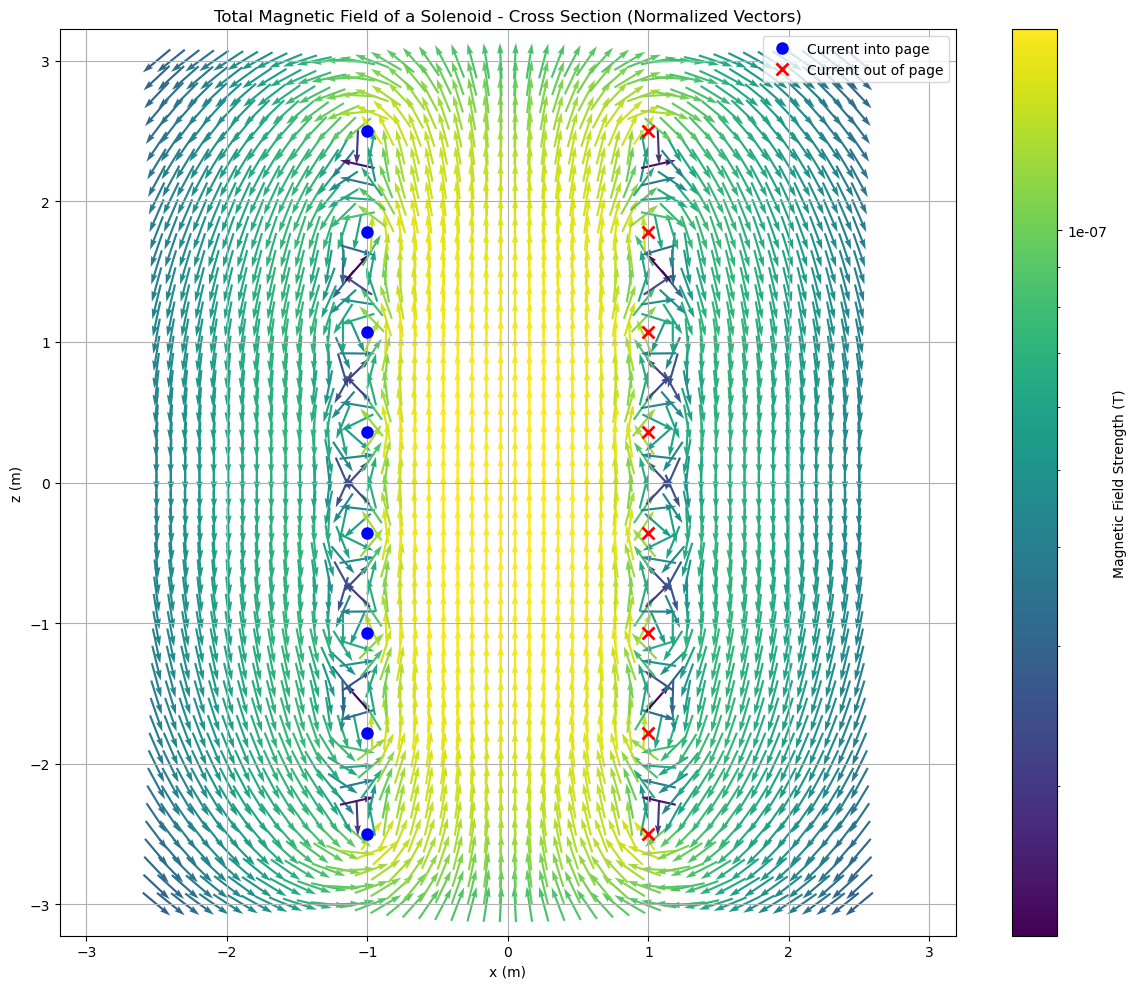

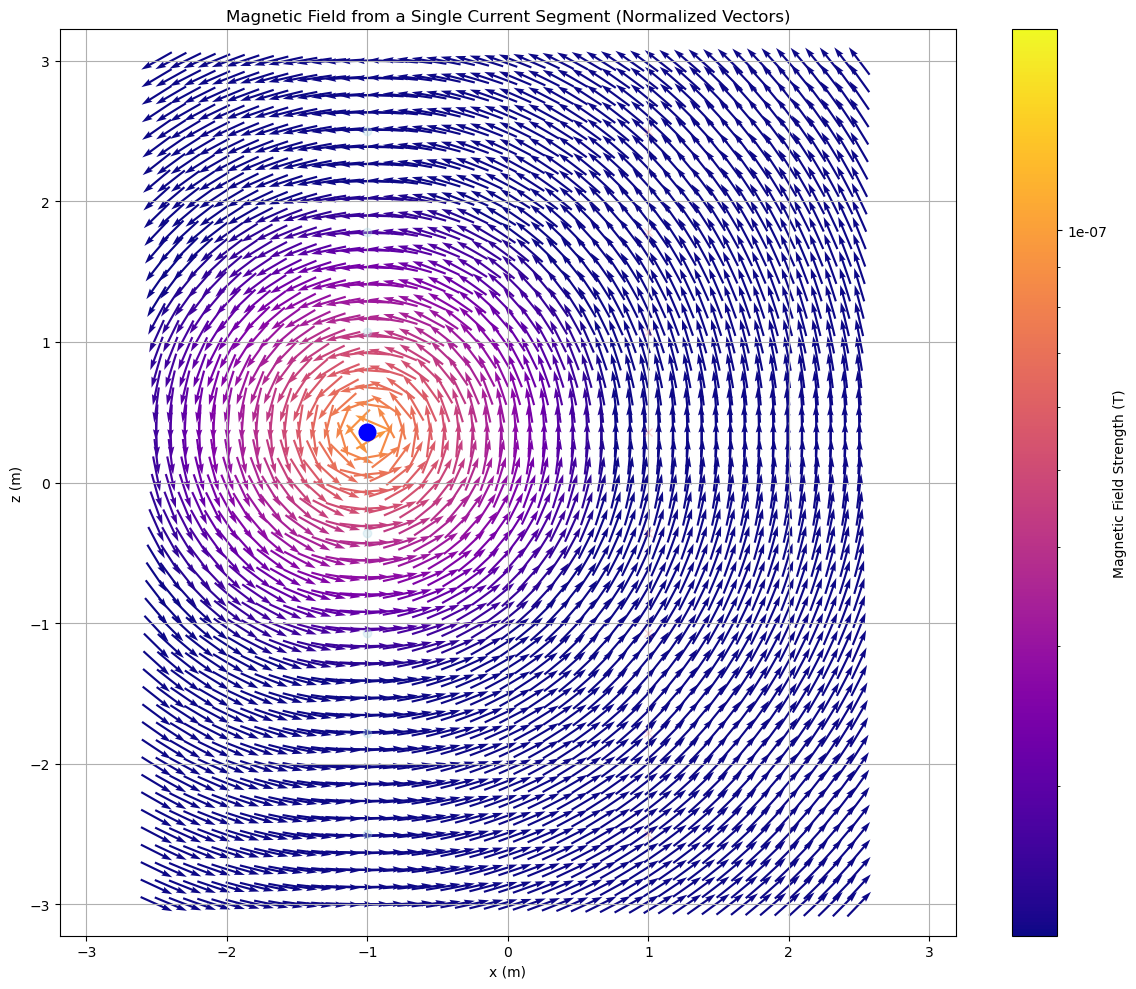

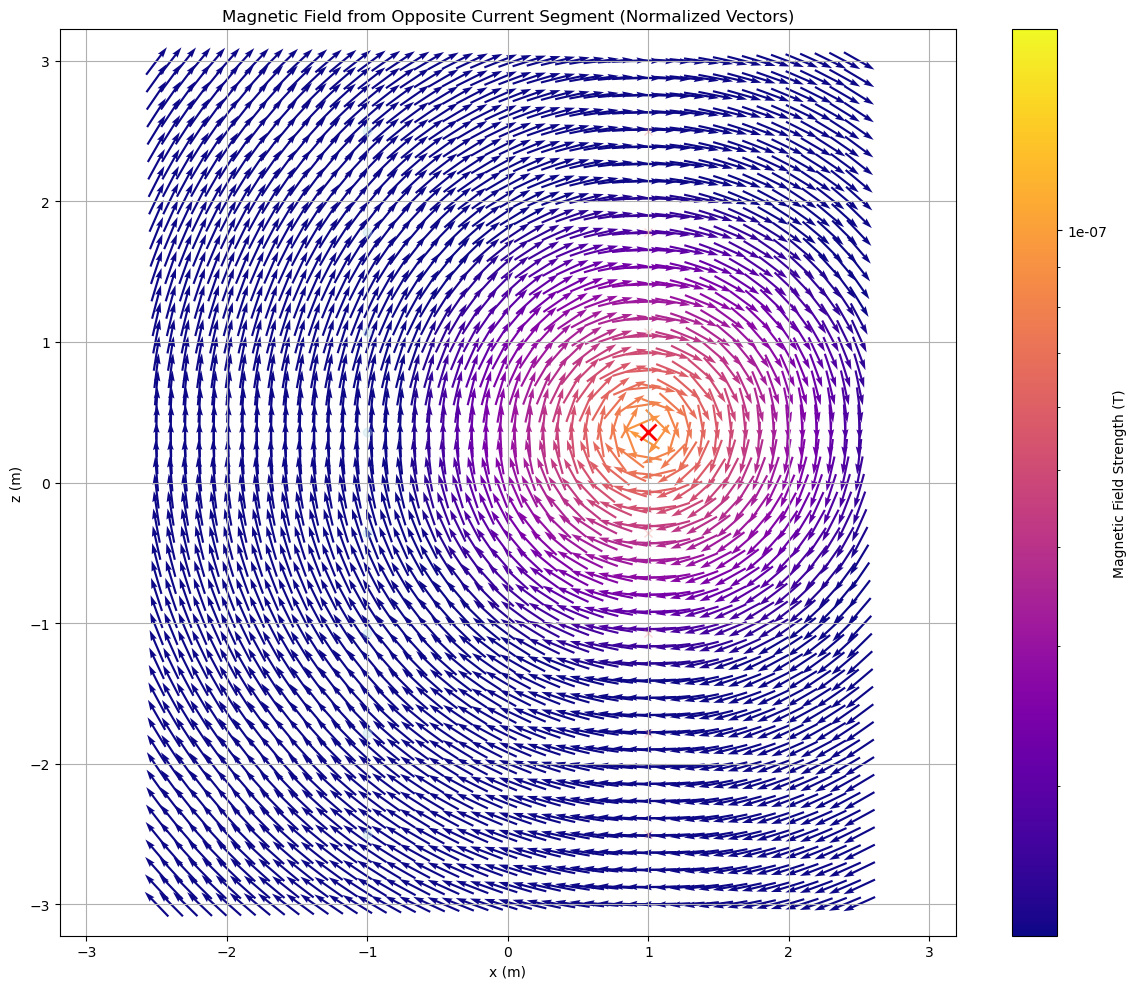

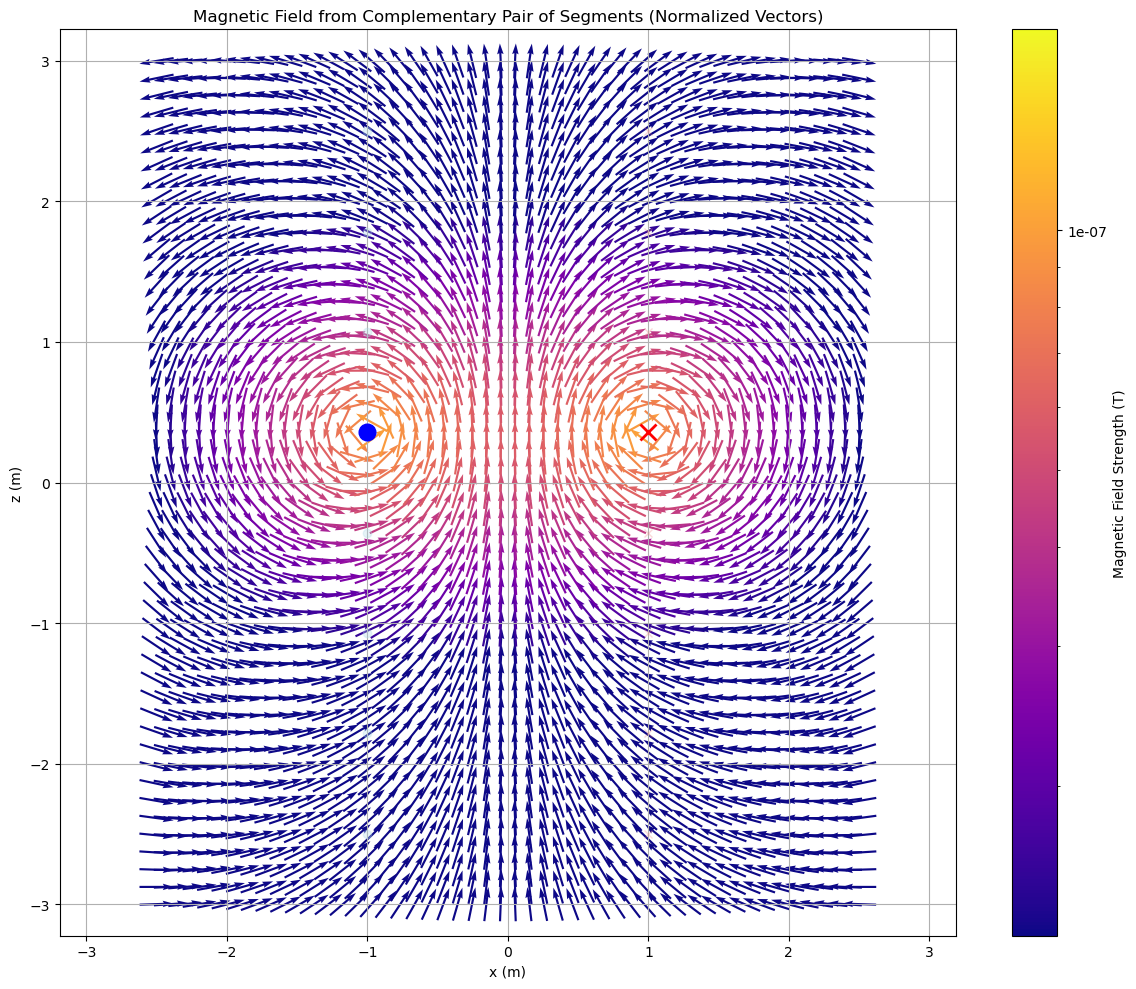

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def biot_savart_current_segment(r, r1, r2, current):
    """
    Calculate magnetic field at point r due to a current segment from r1 to r2
    using the Biot-Savart law.
    
    Parameters:
    - r: observation point [x, y, z]
    - r1: starting point of current segment [x1, y1, z1]
    - r2: ending point of current segment [x2, y2, z2]
    - current: current through the segment in Amperes
    
    Returns:
    - B: magnetic field vector at point r [Bx, By, Bz]
    """
    mu0 = 4 * np.pi * 1e-7  # vacuum permeability
    
    # Convert to numpy arrays
    r = np.array(r)
    r1 = np.array(r1)
    r2 = np.array(r2)
    
    # Calculate current element dl = r2 - r1
    dl = r2 - r1
    
    # Distance vector from r1 to observation point
    R1 = r - r1
    # Distance vector from r2 to observation point
    R2 = r - r2
    
    # Magnitude of R1 and R2
    R1_mag = np.linalg.norm(R1)
    R2_mag = np.linalg.norm(R2)
    
    # To avoid division by zero
    if R1_mag < 1e-10 or R2_mag < 1e-10:
        return np.zeros(3)
    
    # Calculate the Biot-Savart contribution using the segment formula
    # This is equivalent to the integral of dl × r̂/r² over the segment
    cross_term = np.cross(dl, (R1 / R1_mag - R2 / R2_mag))
    
    # Calculate magnetic field using Biot-Savart law
    B = (mu0 * current / (4 * np.pi)) * cross_term
    
    return B

def create_solenoid_cross_section(radius, height, n_turns):
    """
    Create points for a cross-section of a solenoid with straight line segments.
    
    Parameters:
    - radius: radius of the solenoid
    - height: height of the solenoid
    - n_turns: number of turns
    
    Returns:
    - segments: list of (r1, r2) pairs representing current segments
    """
    segments = []
    
    # Calculate spacing between turns
    spacing = height / (n_turns - 1) if n_turns > 1 else 0
    
    # Create straight line segments for the cross-section (x-z plane, y=0)
    for i in range(n_turns):
        z_pos = -height/2 + i * spacing
        
        # Left side (current flowing into the page, y-direction)
        left_segment = ((-radius, 0, z_pos), (-radius, -1, z_pos))
        segments.append(left_segment)
        
        # Right side (current flowing out of the page, y-direction)
        right_segment = ((radius, 0, z_pos), (radius, 1, z_pos))
        segments.append(right_segment)
    
    return segments

def calculate_magnetic_field_from_segment(observation_points, segment, current):
    """
    Calculate magnetic field at multiple observation points due to a single segment.
    
    Parameters:
    - observation_points: list of points where to calculate the field
    - segment: (r1, r2) pair representing a current segment
    - current: current through the segment in Amperes
    
    Returns:
    - B_field: list of magnetic field vectors at each observation point
    """
    r1, r2 = segment
    return [biot_savart_current_segment(point, r1, r2, current) for point in observation_points]

def calculate_total_magnetic_field(observation_points, segments, current):
    """
    Calculate total magnetic field at multiple observation points due to all segments.
    
    Parameters:
    - observation_points: list of points where to calculate the field
    - segments: list of (r1, r2) pairs representing current segments
    - current: current through the segments in Amperes
    
    Returns:
    - B_field: list of magnetic field vectors at each observation point
    """
    # Initialize with zeros
    B_field = [np.zeros(3) for _ in range(len(observation_points))]
    
    # Add contribution from each segment
    for r1, r2 in segments:
        segment_fields = calculate_magnetic_field_from_segment(observation_points, (r1, r2), current)
        for i, B in enumerate(segment_fields):
            B_field[i] += B
    
    return B_field

# Parameters
radius = 1.0  # radius of solenoid in meters
height = 5.0  # height of solenoid in meters
n_turns = 8  # number of turns
current = 1.0  # current in Amperes

# Create solenoid cross-section
segments = create_solenoid_cross_section(radius, height, n_turns)

# Create a denser grid for better visualization (focusing near the solenoid)
# Higher density for zoomed-in view
x = np.linspace(-2.5, 2.5, 50)  # x range from -2.5 to 2.5
z = np.linspace(-3, 3, 50)  # z range from -3 to 3
X, Z = np.meshgrid(x, z)
observation_points = [(X[i, j], 0, Z[i, j]) for i in range(Z.shape[0]) for j in range(Z.shape[1])]

# Calculate total magnetic field
total_B_field = calculate_total_magnetic_field(observation_points, segments, current)

# Reshape for plotting
total_Bx = np.array([B[0] for B in total_B_field]).reshape(Z.shape)
total_By = np.array([B[1] for B in total_B_field]).reshape(Z.shape)
total_Bz = np.array([B[2] for B in total_B_field]).reshape(Z.shape)
total_B_magnitude = np.sqrt(total_Bx**2 + total_By**2 + total_Bz**2)

# For 2D cross-section we use the x and z components only
total_B_xz_magnitude = np.sqrt(total_Bx**2 + total_Bz**2)

# Normalize vectors for plotting
epsilon = 1e-10
total_Bx_norm = total_Bx / (total_B_xz_magnitude + epsilon)
total_Bz_norm = total_Bz / (total_B_xz_magnitude + epsilon)

# Create a log-normalized color scale for better visualization
log_norm = colors.LogNorm(vmin=np.min(total_B_magnitude[total_B_magnitude > 0]),
                          vmax=np.max(total_B_magnitude))

# Create figure for total field
plt.figure(figsize=(12, 10))

# Plot normalized vectors for total field
plt.quiver(X, Z, total_Bx_norm, total_Bz_norm, total_B_magnitude, 
           cmap='viridis', norm=log_norm, pivot='mid', scale=25)

# Plot solenoid cross-section
for i in range(n_turns):
    z_pos = -height/2 + i * (height/(n_turns-1) if n_turns > 1 else 0)
    # Left side dot (current into page)
    plt.plot(-radius, z_pos, 'o', color='blue', markersize=8)
    # Right side cross (current out of page)
    plt.plot(radius, z_pos, 'x', color='red', markersize=8, mew=2)
    
# Add colorbar
cbar = plt.colorbar(label='Magnetic Field Strength (T)', format='%.0e')

# Set labels and title
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Total Magnetic Field of a Solenoid - Cross Section (Normalized Vectors)')
plt.axis('equal')
plt.grid(True)

# Add a legend for current direction
plt.plot([], [], 'o', color='blue', markersize=8, label='Current into page')
plt.plot([], [], 'x', color='red', markersize=8, mew=2, label='Current out of page')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('solenoid_total_field.png', dpi=300)
plt.show()

# Now let's look at the contribution from a SINGLE segment
# Choose a segment from the middle of the solenoid (left side, current into page)
middle_index = n_turns // 2
middle_z = -height/2 + middle_index * (height/(n_turns-1) if n_turns > 1 else 0)
single_segment = ((-radius, 0, middle_z), (-radius, -1, middle_z))

# Calculate field from this single segment
single_segment_field = calculate_magnetic_field_from_segment(observation_points, single_segment, current)

# Reshape for plotting
single_Bx = np.array([B[0] for B in single_segment_field]).reshape(Z.shape)
single_By = np.array([B[1] for B in single_segment_field]).reshape(Z.shape)
single_Bz = np.array([B[2] for B in single_segment_field]).reshape(Z.shape)
single_B_magnitude = np.sqrt(single_Bx**2 + single_By**2 + single_Bz**2)

# For 2D cross-section we use the x and z components only
single_B_xz_magnitude = np.sqrt(single_Bx**2 + single_Bz**2)

# Normalize vectors for plotting
single_Bx_norm = single_Bx / (single_B_xz_magnitude + epsilon)
single_Bz_norm = single_Bz / (single_B_xz_magnitude + epsilon)

# Create figure for single segment
plt.figure(figsize=(12, 10))

# Plot normalized vectors for single segment field
plt.quiver(X, Z, single_Bx_norm, single_Bz_norm, single_B_magnitude, 
           cmap='plasma', norm=log_norm, pivot='mid', scale=25)

# Plot all solenoid segments lightly
for i in range(n_turns):
    z_pos = -height/2 + i * (height/(n_turns-1) if n_turns > 1 else 0)
    # Left side dot (current into page)
    plt.plot(-radius, z_pos, 'o', color='lightblue', markersize=6, alpha=0.3)
    # Right side cross (current out of page)
    plt.plot(radius, z_pos, 'x', color='lightcoral', markersize=6, mew=1, alpha=0.3)

# Highlight the single segment we're examining
plt.plot(-radius, middle_z, 'o', color='blue', markersize=12)

# Add colorbar
cbar = plt.colorbar(label='Magnetic Field Strength (T)', format='%.0e')

# Set labels and title
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Magnetic Field from a Single Current Segment (Normalized Vectors)')
plt.axis('equal')
plt.grid(True)

plt.tight_layout()
plt.savefig('solenoid_single_segment_field.png', dpi=300)
plt.show()

# Now for comparison, look at the opposite segment (right side, current out of page)
opposite_segment = ((radius, 0, middle_z), (radius, 1, middle_z))

# Calculate field from opposite segment
opposite_segment_field = calculate_magnetic_field_from_segment(observation_points, opposite_segment, current)

# Reshape for plotting
opposite_Bx = np.array([B[0] for B in opposite_segment_field]).reshape(Z.shape)
opposite_By = np.array([B[1] for B in opposite_segment_field]).reshape(Z.shape)
opposite_Bz = np.array([B[2] for B in opposite_segment_field]).reshape(Z.shape)
opposite_B_magnitude = np.sqrt(opposite_Bx**2 + opposite_By**2 + opposite_Bz**2)

# For 2D cross-section we use the x and z components only
opposite_B_xz_magnitude = np.sqrt(opposite_Bx**2 + opposite_Bz**2)

# Normalize vectors for plotting
opposite_Bx_norm = opposite_Bx / (opposite_B_xz_magnitude + epsilon)
opposite_Bz_norm = opposite_Bz / (opposite_B_xz_magnitude + epsilon)

# Create figure for opposite segment
plt.figure(figsize=(12, 10))

# Plot normalized vectors for opposite segment field
plt.quiver(X, Z, opposite_Bx_norm, opposite_Bz_norm, opposite_B_magnitude, 
           cmap='plasma', norm=log_norm, pivot='mid', scale=25)

# Plot all solenoid segments lightly
for i in range(n_turns):
    z_pos = -height/2 + i * (height/(n_turns-1) if n_turns > 1 else 0)
    # Left side dot (current into page)
    plt.plot(-radius, z_pos, 'o', color='lightblue', markersize=6, alpha=0.3)
    # Right side cross (current out of page)
    plt.plot(radius, z_pos, 'x', color='lightcoral', markersize=6, mew=1, alpha=0.3)

# Highlight the opposite segment we're examining
plt.plot(radius, middle_z, 'x', color='red', markersize=12, mew=2)

# Add colorbar
cbar = plt.colorbar(label='Magnetic Field Strength (T)', format='%.0e')

# Set labels and title
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Magnetic Field from Opposite Current Segment (Normalized Vectors)')
plt.axis('equal')
plt.grid(True)

plt.tight_layout()
plt.savefig('solenoid_opposite_segment_field.png', dpi=300)
plt.show()

# Finally, compare the field from a complementary pair of segments (left and right at same height)
complementary_pair_field = [np.array(single_segment_field[i]) + np.array(opposite_segment_field[i]) 
                             for i in range(len(observation_points))]

# Reshape for plotting
pair_Bx = np.array([B[0] for B in complementary_pair_field]).reshape(Z.shape)
pair_By = np.array([B[1] for B in complementary_pair_field]).reshape(Z.shape)
pair_Bz = np.array([B[2] for B in complementary_pair_field]).reshape(Z.shape)
pair_B_magnitude = np.sqrt(pair_Bx**2 + pair_By**2 + pair_Bz**2)

# For 2D cross-section we use the x and z components only
pair_B_xz_magnitude = np.sqrt(pair_Bx**2 + pair_Bz**2)

# Normalize vectors for plotting
pair_Bx_norm = pair_Bx / (pair_B_xz_magnitude + epsilon)
pair_Bz_norm = pair_Bz / (pair_B_xz_magnitude + epsilon)

# Create figure for complementary pair
plt.figure(figsize=(12, 10))

# Plot normalized vectors for complementary pair field
plt.quiver(X, Z, pair_Bx_norm, pair_Bz_norm, pair_B_magnitude, 
           cmap='plasma', norm=log_norm, pivot='mid', scale=25)

# Plot all solenoid segments lightly
for i in range(n_turns):
    z_pos = -height/2 + i * (height/(n_turns-1) if n_turns > 1 else 0)
    if i != middle_index:
        # Left side dot (current into page)
        plt.plot(-radius, z_pos, 'o', color='lightblue', markersize=6, alpha=0.3)
        # Right side cross (current out of page)
        plt.plot(radius, z_pos, 'x', color='lightcoral', markersize=6, mew=1, alpha=0.3)

# Highlight the pair we're examining
plt.plot(-radius, middle_z, 'o', color='blue', markersize=12)
plt.plot(radius, middle_z, 'x', color='red', markersize=12, mew=2)

# Add colorbar
cbar = plt.colorbar(label='Magnetic Field Strength (T)', format='%.0e')

# Set labels and title
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Magnetic Field from Complementary Pair of Segments (Normalized Vectors)')
plt.axis('equal')
plt.grid(True)

plt.tight_layout()
plt.savefig('solenoid_pair_field.png', dpi=300)
plt.show()